In [1]:
using FurutaPendulums

In [2]:
using Random
using IntervalSets
using Plots, ReinforcementLearning

In [29]:
mutable struct FurutaEnv <: AbstractEnv
    state
    reward::AbstractFloat
    action_space
    action::AbstractFloat
    state_space
    done
    furuta
    t
    dt
    tmax
end

function FurutaEnv(;
        max_u=5.,
        max_dθ=100.,
        max_dϕ=100.,
        dt = 0.002,
        tmax = 10.
        )
    high = [2pi,max_dθ,2pi,max_dϕ]
    low = [0,-max_dθ,0,-max_dϕ]
    furuta = SimulatedFurutaPendulum()
    FurutaEnv(
        furuta.x,
        0.,
        ClosedInterval.(-max_u,max_u),
        0.,
        Space(ClosedInterval{Float64}.(low, high)),
        false,
        furuta,
        0.,
        dt,
        tmax
        )
end

RLBase.action_space(env::FurutaEnv) = env.action_space
RLBase.state_space(env::FurutaEnv) = env.state_space
function RLBase.reward(env::FurutaEnv)
    ϕ, ϕdot, θ, θdot = env.furuta.x
    costs = θ^2 + 0.1 * θdot^2 + 0.001 * env.action^2
end
RLBase.is_terminated(env::FurutaEnv) = env.done
RLBase.state(env::FurutaEnv) = env.state

function (env::FurutaEnv)(a::AbstractFloat)
    @assert a in env.action_space
    env.action = a
    dt = env.dt
    control(env.furuta,a)
    periodic_wait(env.furuta,env.t,dt)
    env.state[:] = env.furuta.x[:]
    env.t += dt
    env.done = env.t >= env.tmax
    nothing
end

function RLBase.reset!(env::FurutaEnv)
    env.action = 0.
    env.reward = 0.
    env.t = 0.
    env.furuta = SimulatedFurutaPendulum()
    env.state = env.furuta.x
    env.done = false
end

In [25]:
env = FurutaEnv(max_u=5,
        max_dθ=100,
        max_dϕ=100)
env(2.)

In [37]:
run(
           RandomPolicy(),
           FurutaEnv(),
           StopAfterEpisode(10),
           TotalRewardPerEpisode()
       )

                ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
                ┌────────────────────────────────────────┐ 
         300000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡿⡀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⢇⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⢸⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃⠀⠀⡇⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸⠀⠀⠀⢱⠀⠀│ 
   Score        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠘⡄⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⢣⠀│ 
                │⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠸⡀│ 
                │⠀⠀⡠⠔⠙⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃⠀⠀⠀⠀⠀⠀⡇│ 
                │⠔⠉⠀⠀⠀⠈⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸⠀⠀⠀⠀⠀⠀⠀⢸│ 
                │⠀⠀⠀⠀⠀⠀⠈⢆⠀⠀⠀⠀⢀⣀⣀⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠈│ 
                │⠀⠀⠀⠀⠀⠀⠀⠈⢆⢀⠤⠒⠁⠀⠀⠀⠀⠀⠉⠑⠒⠤⢄⡀⠀⠀⠀⠀⡠⠒⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         100000 │⠀⠀⠀⠀⠀⠀⠀⠀⠈⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

TotalRewardPerEpisode([145624.16470267886, 166917.25424421346, 110401.12029180618, 129243.58445131444, 127240.88988478173, 117393.11321826516, 104666.1850578111, 132100.78831875155, 277731.0077699516, 137071.30634833494], 0.0, true)

[ Info: Saved animation to /home/julien/lth/proj/group-2/src/anim_pendulum.gif


Plots.AnimatedGif("/home/julien/lth/proj/group-2/src/anim_pendulum.gif")
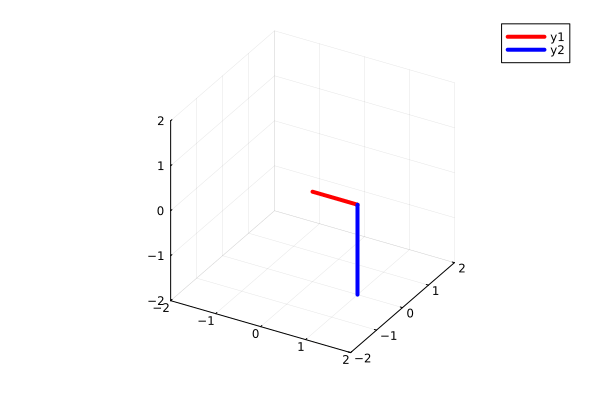

In [19]:
include("sim/env.jl")
function policy(x,t)
    ifelse(t<2,2.5,0.)
end
env = FurutaEnv()
dt = 0.002
tmax = 10.
tspan = 0.:dt:tmax
xs = zeros(length(tspan),4)
for (i,t) in enumerate(tspan)
    xs[i,:] = env.state
    u = policy(env.state,t)
    env(u)
end
plot(tspan,xs)
animate_pendulum(xs[:,1],xs[:,3],tmax)

In [43]:
using ReinforcementLearning
using StableRNGs
using Flux
using Flux.Losses
using IntervalSets

function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:TD3},
    ::Val{:Pendulum},
    ::Nothing;
    seed = 123,
)
    rng = StableRNG(seed)
    inner_env = FurutaEnv()
    A = action_space(inner_env)
    low = A.left
    high = A.right
    ns = length(state(inner_env))

    env = ActionTransformedEnv(
        inner_env;
        action_mapping = x -> low + (x + 1) * 0.5 * (high - low),
    )
    init = glorot_uniform(rng)

    create_actor() = Chain(
        Dense(ns, 30, relu; init = init),
        Dense(30, 30, relu; init = init),
        Dense(30, 1, tanh; init = init),
    ) |> gpu

    create_critic_model() = Chain(
        Dense(ns + 1, 30, relu; init = init),
        Dense(30, 30, relu; init = init),
        Dense(30, 1; init = init),
    ) |> gpu

    create_critic() = TD3Critic(create_critic_model(), create_critic_model())

    agent = Agent(
        policy = TD3Policy(
            behavior_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            behavior_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            target_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            target_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            γ = 0.99f0,
            ρ = 0.99f0,
            batch_size = 64,
            start_steps = 1000,
            start_policy = RandomPolicy(-1.0..1.0; rng = rng),
            update_after = 1000,
            update_freq = 1,
            policy_freq = 2,
            target_act_limit = 1.0,
            target_act_noise = 0.1,
            act_limit = 1.0,
            act_noise = 0.1,
            rng = rng,
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = 10_000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (),
        ),
    )

    stop_condition = StopAfterStep(10_000, is_show_progress=!haskey(ENV, "CI"))
    hook = TotalRewardPerEpisode()
    Experiment(agent, env, stop_condition, hook, "# Play Pendulum with TD3")
end

using Plots
ex = E`JuliaRL_TD3_Pendulum`
run(ex)
plot(ex.hook.rewards)

LoadError: ArgumentError: Package StableRNGs not found in current path.
- Run `import Pkg; Pkg.add("StableRNGs")` to install the StableRNGs package.

In [63]:
using Random
T = Float64
p_env = PendulumEnv(;
    max_speed = T(8),
    max_torque = T(2),
    g = T(10),
    m = T(1),
    l = T(1),
    dt = T(0.05),
    max_steps = 200,
    continuous = true,
    n_actions = 3,
    rng = Random.GLOBAL_RNG,
)

# PendulumEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{IntervalSets.ClosedInterval{Float64}}}(IntervalSets.ClosedInterval{Float64}[-1.0..1.0, -1.0..1.0, -8.0..8.0])`

## Action Space

`-2.0..2.0`

## Current State

```
[0.6364688777541891, 0.7713023840559051, -1.9105465387477385]
```
